In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, ARIMA
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("planilhas/dfRegressaoDias.csv", sep=';', parse_dates=['Data'], index_col="Data")
display(df)
df.info()

print(len(df['CasosDia']))

split = int(0.7 * len(df))


,CasosDia
Data,
2020-03-15,3
2020-03-16,3
2020-03-17,3
2020-03-18,1
2020-03-19,0
...,...
2023-12-27,3
2023-12-28,6
2023-12-29,6


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2020-03-15 to 2023-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CasosDia  1387 non-null   int64
dtypes: int64(1)
memory usage: 21.7 KB
1387


# ARIMA


In [17]:
parametros_grid = {
    'p': [1],
    'd': [1,2],
    'q': [3]
   }

'''
parametros_grid = {
    'p': [2],
    'd': [1],
    'q': [3]
   }
'''

mseARIMA = []
rmseARIMA = []
maeARIMA = []

parametroP_ARIMA = []
parametroD_ARIMA = []
parametroQ_ARIMA = []
auxMae = 0


bestMse = float('inf')

dfTeste =df[split:]

j=1

maeCalibra = 0
## CALIBRAR
for p in parametros_grid['p']:
    print('Q')
    print(j)
    for d in parametros_grid['d']:
        #print('D')
        for q in parametros_grid['q']:
            try:
                model = ARIMA(df['CasosDia'], order=(p,d,q))
                model_fit = model.fit()
                pred = model_fit.forecast(steps=len(df))
                arima = pred[split:]
                mseCalibra = mean_squared_error(dfTeste, arima).round(2)

                if (mseCalibra < bestMse):
                    bestMse = mseCalibra
                    para_p = p
                    para_d = d
                    para_q = q
            except np.linalg.LinAlgError:
                print(f"Unable to fit model with parameters p={p}, d={d}, q={q}")
                continue
    j += 1            
    

## TREINA
model = ARIMA(df['CasosDia'], order=(para_p,para_d,para_q))
model_fit = model.fit()
pred = model_fit.forecast(steps=len(df))
arima = pred[split:]

mae = mean_absolute_error(dfTeste, arima).round(2)
mse = mean_squared_error(dfTeste, arima).round(2)
rmse = np.sqrt(mse).round(2)

mseARIMA.append(mse)
rmseARIMA.append(rmse)
maeARIMA.append(mae)

parametroP_ARIMA.append(para_p)
parametroD_ARIMA.append(para_d)
parametroQ_ARIMA.append(para_q)


# RESULTADOSSSS !!!!
    
parametroMaisEscolhidoARIMA_p = max(set(parametroP_ARIMA), key=parametroP_ARIMA.count)
parametroMaisEscolhidoARIMA_d = max(set(parametroD_ARIMA), key=parametroD_ARIMA.count)
parametroMaisEscolhidoARIMA_q = max(set(parametroQ_ARIMA), key=parametroQ_ARIMA.count)

media_maeARIMA = np.mean(maeARIMA)
media_mseARIMA = np.mean(mseARIMA)
media_rmseARIMA = np.mean(rmseARIMA)


parametroP_ARIMA.append(parametroMaisEscolhidoARIMA_p)
parametroD_ARIMA.append(parametroMaisEscolhidoARIMA_d)
parametroQ_ARIMA.append(parametroMaisEscolhidoARIMA_q)

maeARIMA.append(media_maeARIMA)
mseARIMA.append(media_mseARIMA)
rmseARIMA.append(media_rmseARIMA)


dfARIMA = pd.DataFrame({
    'p': parametroP_ARIMA,
    'd': parametroD_ARIMA,
    'q': parametroQ_ARIMA,
    'MAE': maeARIMA,
    'MSE': mseARIMA,
    'RMSE': rmseARIMA
})




Q
1


,p,d,q,MAE,MSE,RMSE
0,1,1,3,19.3,1791.64,42.33
1,1,1,3,19.3,1791.64,42.33


NameError: name 'para_SE' is not defined

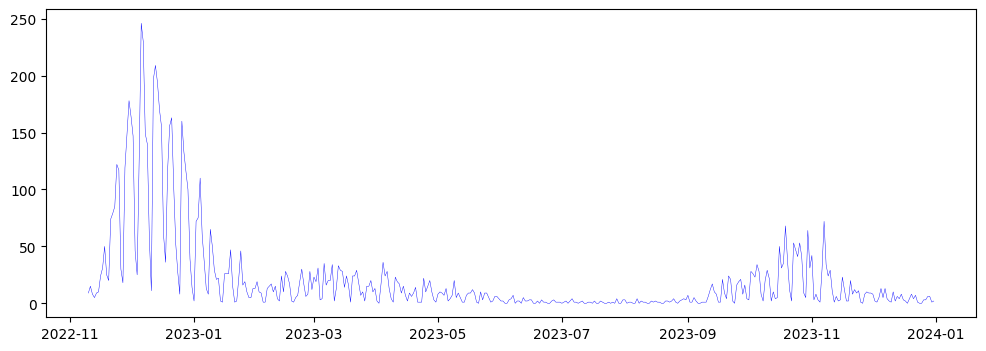

In [18]:
display(dfARIMA)
stringGraf =  'graficos/4-'+ 'ARIMA' + '.pdf'
plt.figure(figsize=(12, 4))
plt.plot(df[split:], label='Valores Reais', color='blue', linewidth=0.3)
plt.plot(df.index[split:], arima, label='Valores Preditos = ' + str(para_SE), color='red', linewidth=0.3)
plt.fill_between(df.index[split:], df[split:].values.flatten(), color='blue', alpha=0.5)
plt.fill_between(df.index[split:], arima, color='red', alpha=0.5)  # Pinta a área entre as linhas
plt.ylabel('Nº de Casos Confirmados')
plt.legend()
plt.savefig(stringGraf, dpi=300, bbox_inches="tight")
plt.show()

n_pred = int(arima.sum())
print('Numero de casos reais: ', df[split:].sum())
print('Numero de casos predito: ', n_pred)